# Many-body dynamical localisation of coupled quantum kicked rotors

L. A. Toikka (lauri.toikka@gmail.com) 

We study here numerically the analytic prediction of the existence of `many-body dynamical localisation' (MBDL) in a system of interacting quantum kicked rotors [1].

[1] L. A. Toikka and A. Andreanov, (2019), arXiv:1901.09362.

https://arxiv.org/abs/1901.09362

### Definitions

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import fftpack
from scipy import special as sfn
from sys import exit


# Global definitions
WFSquared = lambda sWF: np.real(np.multiply(np.conj(sWF),sWF)); # much faster than [np.abs(i2)**2 for i2 in sWF]; 
WFNorm = lambda sWF: np.real(np.dot(np.conj(sWF),sWF));
EvaluateExpectationSquared = lambda sWF,Op: np.dot(WFSquared(sWF),np.multiply(Op,Op))/WFNorm(sWF); # returns <O^2>
EvaluateDensity = lambda sWF: WFSquared(sWF)/WFNorm(sWF);
EvaluateIPR = lambda sWF: np.sum(np.multiply(WFSquared(sWF),WFSquared(sWF)))/(WFNorm(sWF)**2);
EvaluatePR = lambda sWF,VH: 1.0/(EvaluateIPR(sWF)*VH); # VH = size of the Hilbert space = Nbasis_states**2
flatten = lambda l: [item for sublist in l for item in sublist];
TruncateSmallNumbersToZero = lambda l,tol: [(np.real(i2) > tol)*np.real(i2) + (np.imag(i2) > tol)*np.imag(i2)*1j for i2 in l];

INTERACTIONS_none = 1;
INTERACTIONS_MBDL = 2;
INTERACTIONS_weak = 4;
INTERACTIONS_strong = 8;
EVALUATE_PR = 16;
EVALUATE_PR_withplots = 32;
INTERACTIONS_med = 64;

ROTOR1_COLOR = '#42aaf4';
ROTOR2_COLOR = '#c42d41';
ROTOR3_COLOR = '#42f477';

def PrepareInitialWF(b):
    ''' INITIAL state_WF is zero except for support in a random band 
         of width 2*b around the zero-momentum state. This is to 
         smoothen out the results. 
         ONE-particle case. '''
    sWF = np.zeros(Nbasis_states,dtype = complex);
    if (b == 0): 
        sWF[int(Nbasis_states/2.0)] = np.exp(1j*random.uniform(0,2.0*np.pi)); # only zero momentum is populated
    else:
        b = int(b);
        sWF[int(Nbasis_states/2.0) - b:int(Nbasis_states/2.0) + b] = \
                [np.exp(1j*random.uniform(0,2.0*np.pi)) for _ in range(2*b)];
    return sWF/np.sqrt(WFNorm(sWF));

def PrepareInitialWFat(b):
    ''' INITIAL state_WF is zero except for support at site -Nbasis_states/2 < b < Nbasis_states/2
         ONE-particle case. '''
    sWF = np.zeros(Nbasis_states,dtype = complex); 
    sWF[int(Nbasis_states/2) + int(b)] = np.exp(1j*random.uniform(0,2.0*np.pi));
    return sWF/np.sqrt(WFNorm(sWF));
    
    
#
# Plotting routines
#

# Changing plot font size
# (https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
SMALL_SIZE = 20;
MEDIUM_SIZE = 22;
BIGGER_SIZE = 24;

plt.rc('font', size=SMALL_SIZE);          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE);     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE);    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE);    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE);    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE);    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE);  # fontsize of the figure title


def PlotOvsKicks(a1,a2,O,bool_Legend = True):
    '''plot O vs. kicks '''
    plt.xlabel('Kick');
    plt.ylabel(O); 
    plt.plot(range(Nkicks+1),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
    plt.plot(range(Nkicks+1),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
    if (bool_Legend): 
        plt.legend(loc="best");
    plt.savefig("E2.pdf", bbox_inches='tight');
    plt.show();
    
def PlotOvsKicks_3body(a1,a2,a3,O,bool_Legend = True):
    '''plot O vs. kicks '''
    plt.xlabel('Kick');
    plt.ylabel(O); 
    plt.plot(range(Nkicks+1),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
    plt.plot(range(Nkicks+1),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
    plt.plot(range(Nkicks+1),a3, color=ROTOR3_COLOR, alpha=0.9, label=" Rotor 3 ");
    if (bool_Legend): 
        plt.legend(loc="best");
    plt.savefig("E2.pdf", bbox_inches='tight');
    plt.show();
    
def PlotOvsStatespace_1body(a1,a2,O,bool_Log = False, bool_Legend = True):
    '''plot O vs. 1-body state space lattice '''
    plt.xlabel('Angular momentum');
    plt.xticks(np.arange(0, Nbasis_states+1, step=int(Nbasis_states/4)), np.arange(-Nbasis_states/2, Nbasis_states+1, step=int(Nbasis_states/4)));
    plt.ylabel(O); 
    if (bool_Log):
        plt.semilogy(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
        plt.semilogy(range(Nbasis_states),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
    else:
        plt.plot(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
        plt.plot(range(Nbasis_states),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
    
    if (bool_Legend): 
        plt.legend(loc="best");
    plt.savefig("E1.pdf", bbox_inches='tight');
    plt.show();


def PlotOvsStatespace_1body_1rotor(a1,O,bool_Log = False):
    '''plot O vs. 1-body state space lattice '''
    plt.xlabel('Angular momentum');
    plt.xticks(np.arange(0, Nbasis_states+1, step=int(Nbasis_states/4)), np.arange(-Nbasis_states/2, Nbasis_states+1, step=int(Nbasis_states/4)));
    plt.ylabel(O); 
    if (bool_Log):
        plt.semilogy(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9);
    else:
        plt.plot(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9);
    plt.title('A single kicked rotor');
    plt.show();
    
    
def PlotOvsStatespace_2body(a1,O,bool_Log = False):
    '''plot O vs. 1-body state space lattice '''
    plt.xlabel('Angular momentum');
    #plt.xticks(np.arange(0, Nbasis_states**2+1, step=int(Nbasis_states**2/4)), np.arange(-Nbasis_states/2, Nbasis_states+1, step=int(Nbasis_states/4)));
    plt.ylabel(O); 
    if (bool_Log):
        plt.semilogy(range(Nbasis_states**2),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotors 1&2 ");
    else:
        plt.plot(range(Nbasis_states**2),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotors 1&2 ");
    plt.legend(loc="best");
    if (int_Interaction_type == -1):
        plt.title('Non-interacting kicked rotors, averaged over %d runs.' %(Ninitial_states));
    else:
        plt.title('MBL: Interacting kicked rotors, averaged over %d runs.' %(Ninitial_states));
    plt.show();
    
def PlotOvsStatespace_3body(a1,a2,a3,O,bool_Log = False, bool_Legend = True):
    '''plot O vs. 1-body state space lattice '''
    plt.xlabel('Angular momentum');
    plt.xticks(np.arange(0, Nbasis_states+1, step=int(Nbasis_states/4)), np.arange(-Nbasis_states/2, Nbasis_states+1, step=int(Nbasis_states/4)));
    plt.ylabel(O); 
    if (bool_Log):
        plt.semilogy(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
        plt.semilogy(range(Nbasis_states),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
        plt.semilogy(range(Nbasis_states),a3, color=ROTOR3_COLOR, alpha=0.9, label=" Rotor 3 ");
    else:
        plt.plot(range(Nbasis_states),a1, color=ROTOR1_COLOR, alpha=0.9, label=" Rotor 1 ");
        plt.plot(range(Nbasis_states),a2, color=ROTOR2_COLOR, alpha=0.9, label=" Rotor 2 ");
        plt.plot(range(Nbasis_states),a3, color=ROTOR3_COLOR, alpha=0.9, label=" Rotor 3 ");
        
    if (bool_Legend): 
        plt.legend(loc="best");
    plt.savefig("E1.pdf", bbox_inches='tight');
    plt.show();    
    
#
# 
#

def Simulate_2rotors(bool_Legend,int_control):
    '''
        Evaluates <L^2> and density as a function of the global parameters:
            k1               <-> k^(1) kick strength of rotor 1
            k2               <-> k^(2) kick strength of rotor 2
            hbar
            T                <-> kick period
            I                <-> moment of inertia
            Ninitial_states  <-> how many runs average over
            Nbasis_states    <-> L in [-Nbasis_state/2,Nbasis_states/2]. For efficiency with the FFT use a power of 2
            Nkicks           <-> how many kicks to simulate over
            mblV             <-> the parameter V in the tight-binding model
         
        int_control is used to direct the execution flow as follows:  
            INTERACTIONS_none: non-interacting
            INTERACTIONS_MBDL: MBDL
            INTERACTIONS_weak: weak interactions < MBDL
            INTERACTIONS_med: medium interactions > MBDL
            INTERACTIONS_strong: strong interactions > MBDL
            EVALUATE_PR: evaluates the Participation Ratio, and does not plot any 
                         figures unless the flag EVALUATE_PR_withplots is set
            EVALUATE_PR_withplots: include plots           
        (Extensive sanity checking has not been implemented for 
         ambiguous calls such as INTERACTIONS_none+INTERACTIONS_MBDL)
         
         The 2-body basis we use is as follows:
             state_WF_2body is an array of length Nbasis_states**2 with the structure
             state_WF_2body[11, 12, ..., 1Nbasis_states, 21, 22, ..., Nbasis_statesNbasis_states ]
             where 11 = the most negative angular momentum state for both rotors
                   Nbasis_statesNbasis_states = the most positive angular momentum state for both rotors
                   Nbasis_states/2 Nbasis_states/2 = zero-momentum state for both rotors
    '''
    def TrOver(sWF,r):
        if (r == 2): return [np.sum(sWF[i2*Nbasis_states:(i2+1)*Nbasis_states]) for i2 in range(Nbasis_states)];
        elif (r == 1): return [np.sum(sWF[i2::Nbasis_states]) for i2 in range(Nbasis_states)];
        
    def PrepareInitialWFspread_2body(b):
        ''' TWO-particle case. '''
        sWF = np.kron(PrepareInitialWF(b),PrepareInitialWF(b)); 
        return sWF/np.sqrt(WFNorm(sWF));

    def PrepareInitialWFat_2body(b1,b2):
        ''' TWO-particle case. '''
        sWF = np.kron(PrepareInitialWFat(b1),PrepareInitialWFat(b2)); 
        return sWF/np.sqrt(WFNorm(sWF));        
        
     
    def PropagateWF_2body(sWF):
        ''' A split operator propagator for two-particle case. '''
        sWF *= prop_oper_exp_2body; # first propagation in momentum space
        sWF2 = sWF.reshape((Nbasis_states, Nbasis_states),order='C');
        sWF = fftpack.ifft2(sWF2,overwrite_x=True); # inverse FFT to real space
        sWF = np.multiply(kick_oper_exp_2body,sWF); # apply the kick
        sWF = fftpack.fft2(sWF,overwrite_x=True); # back to angular momentum space by an FFT
        return sWF.reshape(Nbasis_states**2);   
    
    
    # Definitions of numbers
    #random.seed(123); # for generating reproducible random sequences
    kbar = hbar*T/I;
    K1 = k1/hbar; # scaled kick strengths
    K2 = k2/hbar;
    arrayL2 = np.zeros(Nkicks+1);
    arrayL22 = np.zeros(Nkicks+1);
    state_ave_2body = np.zeros(Nbasis_states**2,dtype=complex);
    state_Dens = np.zeros(Nbasis_states);
    state_Dens2 = np.zeros(Nbasis_states);
    
    bool_INTERACTIONS_none = int_control & INTERACTIONS_none;
    bool_INTERACTIONS_MBDL = int_control & INTERACTIONS_MBDL;
    bool_INTERACTIONS_weak = int_control & INTERACTIONS_weak;
    bool_INTERACTIONS_med = int_control & INTERACTIONS_med;
    bool_INTERACTIONS_strong = int_control & INTERACTIONS_strong;
    bool_EVALUATE_PR = int_control & EVALUATE_PR;
    bool_EVALUATE_PR_withplots = int_control & EVALUATE_PR_withplots;
    
    if (not bool_INTERACTIONS_none):
        # We will need the parameter c, kbar/2 * sum_i l_i^2. 
        # NB: these are the single-particle angular momenta.
        # l_i = i2 - Nbasis_states/2.0  
        varphisum = np.sum([(i2 - Nbasis_states/2.0)**2 for i2 in range(Nbasis_states)]);
        if (kbar == 4.0 * np.pi): c = 0; # quantum resonances
        else: c = np.mod(((kbar/2)*varphisum), 2.0*np.pi);     
        V0 = mblV/(sfn.jv(0,np.abs(k1))*sfn.jv(0,np.abs(k2)));

        # Prepare the interaction matrix template
        # For the MBL term, we are interested in when the rotors are separated by 1 quantum of ang. mom.  
        # For N = 2 the sum of interacting pairs for any Fock state is (0,1), and is as follows. 
        # For N = 3 we evaluate matMBL_tmp directly as part of the initialisation.
        matMBL_tmp = [];
        for i2 in range(Nbasis_states): 
            if (i2 == 0):  
                matMBL_tmp = np.concatenate((matMBL_tmp, ([0] + [1] + [0]*(Nbasis_states - 2))));
            elif (i2 == Nbasis_states-1):
                matMBL_tmp = np.concatenate((matMBL_tmp, ([0]*(i2-1) + [1] + [0]*(Nbasis_states - i2))));
            else:
                matMBL_tmp = np.concatenate((matMBL_tmp, ([0]*(i2-1) + [1,0,1] + [0]*(Nbasis_states - (i2 + 2)))));

        # The interaction term commutes with the free propagator, so we can write it as a separate EXP as below.
        if (bool_INTERACTIONS_MBDL):
            matMBL = [];
            for i2 in matMBL_tmp:
                V = i2*V0;
                if (V == 0):
                    matMBL += [np.exp(-1j*0)];
                else:
                    tmpSqrtarg = -(V/np.cos(c))*(2 + V/np.cos(c)) + np.tan(c)**2; # With c = 0, >= 0 when -2 <= V <= 0 
                    if (tmpSqrtarg < 0):
                        print(tmpSqrtarg, V);
                        exit('MBL term Sqrt imaginary, H_MBL not Hermitian.');
                    else:
                        yMBL = -(np.sin(c) + V*np.tan(c) + np.cos(c)*np.sqrt(tmpSqrtarg));
                        xMBL = (np.cos(c) + V - np.sin(c)*np.sqrt(tmpSqrtarg)); 
                        matMBL += [np.exp(-1j*np.arctan2(yMBL, xMBL))];            
        elif (bool_INTERACTIONS_strong):
            matMBL = [np.exp(-1j*np.pi*i2) for i2 in matMBL_tmp]; # max. interaction strength
        elif (bool_INTERACTIONS_weak):
            matMBL = [np.exp(-1j*0.05*np.pi*i2) for i2 in matMBL_tmp]; # 5% interaction strength
        elif (bool_INTERACTIONS_med):
            matMBL = [np.exp(-1j*0.15*np.pi*i2) for i2 in matMBL_tmp]; # 15% interaction strength
                
                

    # Definitions of 2-body operators
    kick_oper_exp = [np.exp(-1j*K1*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)]; 
    kick_oper_exp2 = [np.exp(-1j*K2*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)];    
    #kick_oper_exp_i = [np.exp(-1j *1.0*np.cos((i2 - i3)*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states) for i3 in range(Nbasis_states)]; 
    kick_oper_exp_i = [1]*Nbasis_states**2; # No interactions during kicks
    kick_oper_exp_2body = np.multiply(kick_oper_exp_i,np.kron(kick_oper_exp2,kick_oper_exp)).reshape((Nbasis_states, Nbasis_states),order='C'); 
    # Free space propagator:   
    free_prop_oper_exp = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)]; 
    free_prop_oper_exp2 = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)]; 
    free_prop_oper_exp_2body = np.kron(free_prop_oper_exp2,free_prop_oper_exp);
    if (bool_INTERACTIONS_none): prop_oper_exp_2body = np.kron(free_prop_oper_exp2,free_prop_oper_exp);
    else: prop_oper_exp_2body = np.multiply(matMBL, free_prop_oper_exp_2body);
    # diagonal elements of the angular momentum operator in our diagonal basis, used to calculate <L^2>:
    vecMomentum = [(i2 - Nbasis_states/2.0) for i2 in range(Nbasis_states)]; 

    # Simulate for Ninitial_states realisations
    bool_initial_plotted = False;
    for _ in range(Ninitial_states):
        #state_WF_2body = PrepareInitialWFspread_2body(0); 
        #state_WF_2body = PrepareInitialWFat_2body(0,1);
        state_WF_2body = PrepareInitialWFat_2body(-5,10);
        state_WF_2body_r1 = TrOver(state_WF_2body,2);     # Trace over rotor 2 angular momentum degree of freedom  
        state_WF_2body_r2 = TrOver(state_WF_2body,1);     # Trace over rotor 1 angular momentum degree of freedom

        if ((not bool_initial_plotted) and \
            ((not bool_EVALUATE_PR) or (bool_EVALUATE_PR and bool_EVALUATE_PR_withplots))):
            PlotOvsStatespace_1body(EvaluateDensity(state_WF_2body_r1), \
                                    EvaluateDensity(state_WF_2body_r2), 'Initial Density', False, False);
            bool_initial_plotted = True;

        # INITIAL <L^2>
        arrayL2[0] += EvaluateExpectationSquared(state_WF_2body_r1,vecMomentum);
        arrayL22[0] += EvaluateExpectationSquared(state_WF_2body_r2,vecMomentum);

        # TIME PROPAGATION ASF
        for k in range(1,Nkicks+1):
            state_WF_2body = PropagateWF_2body(state_WF_2body);
            state_WF_2body_r1 = TrOver(state_WF_2body,2);   
            state_WF_2body_r2 = TrOver(state_WF_2body,1);
            arrayL2[k] += EvaluateExpectationSquared(state_WF_2body_r1,vecMomentum);
            arrayL22[k] += EvaluateExpectationSquared(state_WF_2body_r2,vecMomentum);

        # Density (in angular momentum space) of this realisation after Nkicks.
        if (np.abs(1 - WFNorm(state_WF_2body)) > 1e-10):
            print('Norm: ',WFNorm(state_WF_2body));
            exit('ERROR: Norm has not been preserved');
        state_Dens += np.array(EvaluateDensity(state_WF_2body_r1));
        state_Dens2 += np.array(EvaluateDensity(state_WF_2body_r2));
        state_ave_2body += np.array(state_WF_2body);

    state_Dens = state_Dens/Ninitial_states;
    state_Dens2 = state_Dens2/Ninitial_states;
    state_ave_2body = state_ave_2body/Ninitial_states;

    # Inverse Participation Ratio.
    if (bool_EVALUATE_PR):
        if (bool_EVALUATE_PR_withplots):
            print(np.log(EvaluatePR(state_ave_2body,Nbasis_states**2)));
        else:
            return np.log(EvaluatePR(state_ave_2body,Nbasis_states**2));
    
    PlotOvsStatespace_1body(state_Dens, state_Dens2, 'Density ($t/T = %d$)' %(Nkicks),True,bool_Legend);

    arrayL2 = arrayL2/Ninitial_states;
    arrayL22 = arrayL22/Ninitial_states;
    # arrayL2 contains the average of <L^2> for rotor 1 over Ninitial_states 
    # realisations as a function of kick, i.e. arrayL2[0, 1, ..., Nkicks]
    PlotOvsKicks(arrayL2, arrayL22,'$< L^2 >$',bool_Legend);
    
    
    
    
    
    
    
#    
# 3 rotors    
#
def Simulate_3rotors(bool_Legend,int_control):
    '''
        Evaluates <L^2> and density as a function of the global parameters:
            k1               <-> k^(1) kick strength of rotor 1
            k2               <-> k^(2) kick strength of rotor 2
            k3               <-> k^(3) kick strength of rotor 3
            hbar
            T                <-> kick period
            I                <-> moment of inertia
            Ninitial_states  <-> how many runs average over
            Nbasis_states    <-> L in [-Nbasis_state/2,Nbasis_states/2]. For efficiency with the FFT use a power of 2
            Nkicks           <-> how many kicks to simulate over
            mblV             <-> the parameter V in the tight-binding model
         
        int_control is used to direct the execution flow as follows:  
            INTERACTIONS_none: non-interacting
            INTERACTIONS_MBDL: MBDL
            INTERACTIONS_weak: weak interactions < MBDL
            INTERACTIONS_med: medium interactions > MBDL
            INTERACTIONS_strong: strong interactions > MBDL
            EVALUATE_PR: evaluates the Participation Ratio, and does not plot any 
                         figures unless the flag EVALUATE_PR_withplots is set
            EVALUATE_PR_withplots: include plots           
        (Extensive sanity checking has not been implemented for 
         ambiguous calls such as INTERACTIONS_none+INTERACTIONS_MBDL)
         
         The 3-body basis we use is as follows:
             state_WF_3body is an array of length Nbasis_states**3 with the structure
             state_WF_2body[111, 112, ..., 11Nbasis_states, 
                            121, 122, ..., 12Nbasis_states
                               ...
                            1Nbasis_states1, 1Nbasis_states2, ..., 1Nbasis_statesNbasis_states                            
                            211, 212, ..., 21Nbasis_states, 
                            221, 222, ..., 22Nbasis_states
                               ...
                            2Nbasis_states1, 2Nbasis_states2, ..., 2Nbasis_statesNbasis_states 
                               ... ...
                            Nbasis_states11, Nbasis_states12, ..., Nbasis_states1Nbasis_states, 
                            Nbasis_states21, Nbasis_states22, ..., Nbasis_states2Nbasis_states
                               ...
                            Nbasis_statesNbasis_states1, Nbasis_statesNbasis_states2, ..., Nbasis_statesNbasis_statesNbasis_states                                   
                            ]
             where 111 = the most negative angular momentum state for all rotors
                   Nbasis_statesNbasis_statesNbasis_states = the most positive angular momentum state for all rotors
                   Nbasis_states/2 Nbasis_states/2 Nbasis_states/2 = zero-momentum state for all rotors
    '''                   
    def TrOver(sWF,r):
        ''' Here r = ij where trace over rotors i and j (i < j) '''
        if (r == 23): return [np.sum(sWF[i2*Nbasis_states**2:(i2+1)*Nbasis_states**2]) for i2 in range(Nbasis_states)];
        elif (r == 12): return [np.sum(sWF[i2::Nbasis_states]) for i2 in range(Nbasis_states)];
        elif (r == 13):
            ret = np.zeros(Nbasis_states,dtype=complex);
            for i2 in range(Nbasis_states):
                for i3 in range(Nbasis_states):
                    ret[i2] += np.sum(sWF[i2*Nbasis_states + i3*Nbasis_states**2:\
                                          i2*Nbasis_states + i3*Nbasis_states**2 + Nbasis_states]);  
   
            return ret;        
                 
    def PrepareInitialWFspread_3body(b):
        ''' THREE-particle case. '''
        sWF = np.kron(PrepareInitialWF(b),np.kron(PrepareInitialWF(b),PrepareInitialWF(b))); 
        return sWF/np.sqrt(WFNorm(sWF));

    def PrepareInitialWFat_3body(b1,b2,b3):
        ''' THREE-particle case. '''
        sWF = np.kron(PrepareInitialWFat(b1),np.kron(PrepareInitialWFat(b2),PrepareInitialWFat(b3))); 
        return sWF/np.sqrt(WFNorm(sWF));        
        
     
    def PropagateWF_3body(sWF):
        ''' A split operator propagator for three-particle case. '''
        sWF *= prop_oper_exp_3body; # first propagation in momentum space
        sWF2 = sWF.reshape((Nbasis_states, Nbasis_states, Nbasis_states),order='C');
        sWF = fftpack.ifftn(sWF2,overwrite_x=True); # inverse FFT to real space
        sWF = np.multiply(kick_oper_exp_3body,sWF); # apply the kick
        sWF = fftpack.fftn(sWF,overwrite_x=True); # back to angular momentum space by an FFT
        return sWF.reshape(Nbasis_states**3);   
    
    
    # Definitions of numbers
    #random.seed(123); # for generating reproducible random sequences
    kbar = hbar*T/I;
    K1 = k1/hbar; # scaled kick strengths
    K2 = k2/hbar;
    K3 = k3/hbar;
    arrayL2 = np.zeros(Nkicks+1);
    arrayL22 = np.zeros(Nkicks+1);
    arrayL23 = np.zeros(Nkicks+1);
    state_ave_3body = np.zeros(Nbasis_states**3,dtype=complex);
    state_Dens = np.zeros(Nbasis_states);
    state_Dens2 = np.zeros(Nbasis_states);
    state_Dens3 = np.zeros(Nbasis_states);

    
    bool_INTERACTIONS_none = int_control & INTERACTIONS_none;
    bool_INTERACTIONS_MBDL = int_control & INTERACTIONS_MBDL;
    bool_INTERACTIONS_weak = int_control & INTERACTIONS_weak;
    bool_INTERACTIONS_med = int_control & INTERACTIONS_med;
    bool_INTERACTIONS_strong = int_control & INTERACTIONS_strong;
    bool_EVALUATE_PR = int_control & EVALUATE_PR;
    bool_EVALUATE_PR_withplots = int_control & EVALUATE_PR_withplots;
    

    if (not bool_INTERACTIONS_none):
        # We will need the parameter c, kbar/2 * sum_i l_i^2. 
        # NB: these are the single-particle angular momenta.
        # l_i = i2 - Nbasis_states/2.0  
        varphisum = np.sum([(i2 - Nbasis_states/2.0)**2 for i2 in range(Nbasis_states)]);
        if (kbar == 4.0 * np.pi): c = 0; # quantum resonances
        else: c = np.mod(((kbar/2)*varphisum), 2.0*np.pi);     
        V0 = mblV/(sfn.jv(0,np.abs(k1))*sfn.jv(0,np.abs(k2))*sfn.jv(0,np.abs(k3)));

        # Prepare the interaction matrix template
        # For the MBL term, we are interested in when the rotors are separated by 1 quantum of ang. mom.     
        ''' The interaction template matMBL_tmp multiplies the state by i where i = number of pairs in that state '''
        matMBL_tmp = [];
        for i1 in range(Nbasis_states):
            for i2 in range(Nbasis_states):
                for i3 in range(Nbasis_states):
                        #tmpcount = 1*(np.abs(i1 - i2) == 1) + 1*(np.abs(i1 - i3) == 1) + 1*(np.abs(i2 - i3) == 1); 
                        # np.abs is slow
                        tmpcount = 1*((i1 - i2 == 1) or (-i1 + i2 == 1)) + \
                        1*((i1 - i3 == 1) or (-i1 + i3 == 1)) + \
                        1*((i2 - i3 == 1) or (-i2 + i3 == 1));
                        matMBL_tmp += [tmpcount];

        # The interaction term commutes with the free propagator, so we can write it as a separate EXP as below.
        if (bool_INTERACTIONS_MBDL):
            matMBL = [];
            for i2 in matMBL_tmp:
                V = i2*V0;
                if (V == 0):
                    matMBL += [np.exp(-1j*0)];
                else:
                    tmpSqrtarg = -(V/np.cos(c))*(2 + V/np.cos(c)) + np.tan(c)**2;
                    if (tmpSqrtarg < 0):
                        print(tmpSqrtarg, V);
                        exit('(N=3) MBL term Sqrt imaginary, H_MBL not Hermitian.');
                    else:
                        yMBL = -(np.sin(c) + V*np.tan(c) + np.cos(c)*np.sqrt(tmpSqrtarg));
                        xMBL = (np.cos(c) + V - np.sin(c)*np.sqrt(tmpSqrtarg)); 
                        matMBL += [np.exp(-1j*np.arctan2(yMBL, xMBL))];                                   
        elif (bool_INTERACTIONS_strong):
            matMBL = [np.exp(-1j*np.pi*i2) for i2 in matMBL_tmp]; # max. interaction strength
        elif (bool_INTERACTIONS_weak):
            matMBL = [np.exp(-1j*0.05*np.pi*i2) for i2 in matMBL_tmp]; # 5% interaction strength
        elif (bool_INTERACTIONS_med):
            matMBL = [np.exp(-1j*0.15*np.pi*i2) for i2 in matMBL_tmp]; # 15% interaction strength                                   
                 
    # Definitions of 3-body operators
    kick_oper_exp = [np.exp(-1j*K1*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)]; 
    kick_oper_exp2 = [np.exp(-1j*K2*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)];    
    kick_oper_exp3 = [np.exp(-1j*K3*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)]; 
    kick_oper_exp_i = [1]*Nbasis_states**3; # No interactions during kicks
    kick_oper_exp_3body = np.multiply(kick_oper_exp_i,np.kron(kick_oper_exp3,np.kron(kick_oper_exp2,kick_oper_exp))).reshape((Nbasis_states, Nbasis_states, Nbasis_states),order='C'); 
    # Free space propagator:   
    free_prop_oper_exp = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)]; 
    free_prop_oper_exp2 = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)]; 
    free_prop_oper_exp3 = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)]; 
    free_prop_oper_exp_3body = np.kron(free_prop_oper_exp3,np.kron(free_prop_oper_exp2,free_prop_oper_exp));
    if (bool_INTERACTIONS_none): 
        prop_oper_exp_3body =  np.kron(free_prop_oper_exp3,np.kron(free_prop_oper_exp2,free_prop_oper_exp));
    else: prop_oper_exp_3body = np.multiply(matMBL, free_prop_oper_exp_3body);
    # diagonal elements of the angular momentum operator in our diagonal basis, used to calculate <L^2>:
    vecMomentum = [(i2 - Nbasis_states/2.0) for i2 in range(Nbasis_states)]; 


    
    # Simulate for Ninitial_states realisations
    bool_initial_plotted = False;
    for _ in range(Ninitial_states):
        #state_WF_3body = PrepareInitialWFspread_3body(0); 
        state_WF_3body = PrepareInitialWFat_3body(-1,0,1);
        state_WF_3body_r1 = TrOver(state_WF_3body,23);     # Trace over rotors 23 angular momentum degree of freedom  
        state_WF_3body_r2 = TrOver(state_WF_3body,13);     # Trace over rotors 13 angular momentum degree of freedom
        state_WF_3body_r3 = TrOver(state_WF_3body,12);     # Trace over rotors 12 angular momentum degree of freedom      
        
        if ((not bool_initial_plotted) and \
            ((not bool_EVALUATE_PR) or (bool_EVALUATE_PR and bool_EVALUATE_PR_withplots))):
            PlotOvsStatespace_3body(EvaluateDensity(state_WF_3body_r1), \
                                    EvaluateDensity(state_WF_3body_r2), \
                                    EvaluateDensity(state_WF_3body_r3), 'Initial Density', False, False);
            bool_initial_plotted = True;

        
        # INITIAL <L^2>
        arrayL2[0] += EvaluateExpectationSquared(state_WF_3body_r1,vecMomentum);
        arrayL22[0] += EvaluateExpectationSquared(state_WF_3body_r2,vecMomentum);
        arrayL23[0] += EvaluateExpectationSquared(state_WF_3body_r3,vecMomentum);

        
        # TIME PROPAGATION
        for k in range(1,Nkicks+1):
            state_WF_3body = PropagateWF_3body(state_WF_3body);
            state_WF_3body_r1 = TrOver(state_WF_3body,23);  
            state_WF_3body_r2 = TrOver(state_WF_3body,13);  
            state_WF_3body_r3 = TrOver(state_WF_3body,12);  

            arrayL2[k] += EvaluateExpectationSquared(state_WF_3body_r1,vecMomentum);
            arrayL22[k] += EvaluateExpectationSquared(state_WF_3body_r2,vecMomentum);
            arrayL23[k] += EvaluateExpectationSquared(state_WF_3body_r3,vecMomentum);

        # Density (in angular momentum space) of this realisation after Nkicks.
        if (np.abs(1 - WFNorm(state_WF_3body)) > 1e-10):
            print('Norm: ',WFNorm(state_WF_3body));
            exit('ERROR: Norm has not been preserved');
        state_Dens += np.array(EvaluateDensity(state_WF_3body_r1));
        state_Dens2 += np.array(EvaluateDensity(state_WF_3body_r2));
        state_Dens3 += np.array(EvaluateDensity(state_WF_3body_r3));
        state_ave_3body += np.array(state_WF_3body);

    state_Dens = state_Dens/Ninitial_states;
    state_Dens2 = state_Dens2/Ninitial_states;
    state_Dens3 = state_Dens3/Ninitial_states;
    state_ave_3body = state_ave_3body/Ninitial_states;

    # Inverse Participation Ratio.
    if (bool_EVALUATE_PR):
        if (bool_EVALUATE_PR_withplots):
            print(np.log(EvaluatePR(state_ave_3body,Nbasis_states**3)));
        else:
            return np.log(EvaluatePR(state_ave_3body,Nbasis_states**3));
    
    PlotOvsStatespace_3body(state_Dens, state_Dens2, state_Dens3,'Density ($t/T = %d$)' %(Nkicks),True,bool_Legend);

    arrayL2 = arrayL2/Ninitial_states;
    arrayL22 = arrayL22/Ninitial_states;
    arrayL23 = arrayL23/Ninitial_states;
    # arrayL2 contains the average of <L^2> for rotor 1 over Ninitial_states 
    # realisations as a function of kick, i.e. arrayL2[0, 1, ..., Nkicks]
    PlotOvsKicks_3body(arrayL2, arrayL22, arrayL23, '$< L^2 >$',bool_Legend);

## $N=3$ ($I = 0.1$), Interactions change dynamics for $\chi = 16$ 

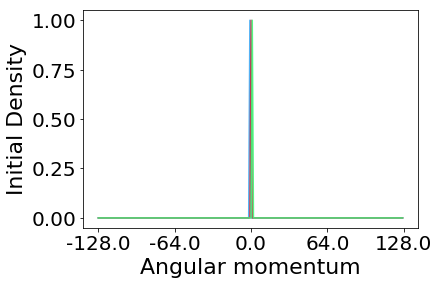

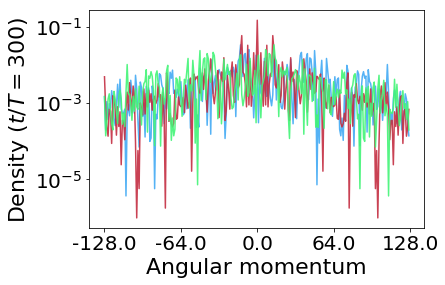

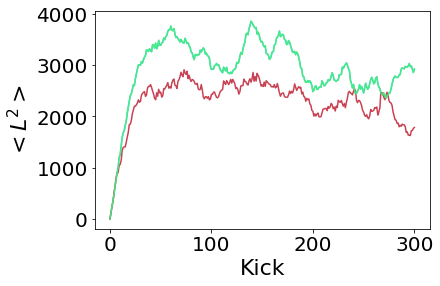

In [12]:
# Fig 1e,f
# Parameters
k1 = 16.0; # k^(1) kick strength of rotor 1
k2 = 16.0; # k^(2) kick strength of rotor 2
k3 = 16.0; # k^(3) kick strength of rotor 3
hbar = 1.0; #4.0*np.pi;
T = 1.0; # kick period
I = 0.1; # moment of inertia
Ninitial_states = 1; # how many runs average over
Nbasis_states = 256; #2048; #512 # for efficiency with the FFT use a power of 2
Nkicks = 300; #2500
mblV = 0.001; #mblV is the parameter V in the MBL hamiltonian, needs to be taken small enough

Simulate_3rotors(False, INTERACTIONS_none);

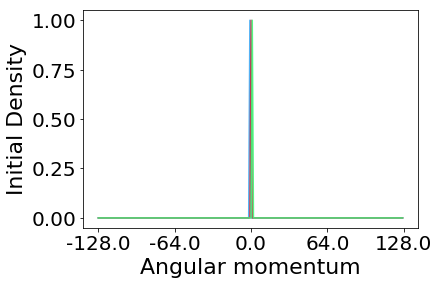

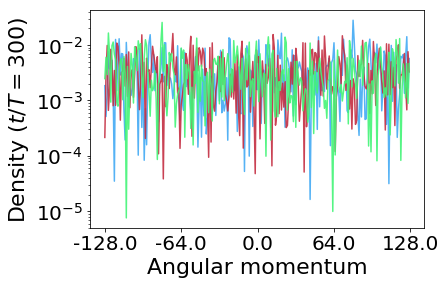

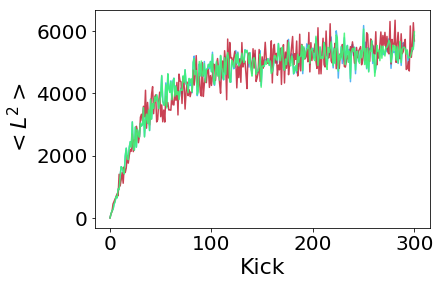

In [87]:
# Fig 1g,h
# Parameters
k1 = 16.0; # k^(1) kick strength of rotor 1
k2 = 16.0; # k^(2) kick strength of rotor 2
k3 = 16.0; # k^(3) kick strength of rotor 3
hbar = 1.0; #4.0*np.pi;#1.0;
T = 1.0; # kick period
I = 0.1; # moment of inertia
Ninitial_states = 1; # how many runs average over
Nbasis_states = 256; #2048; #512 # for efficiency with the FFT use a power of 2
Nkicks = 300; #2500
mblV = 0.001; #mblV is the parameter V in the MBL hamiltonian, needs to be taken small enough

Simulate_3rotors(False, INTERACTIONS_MBDL);

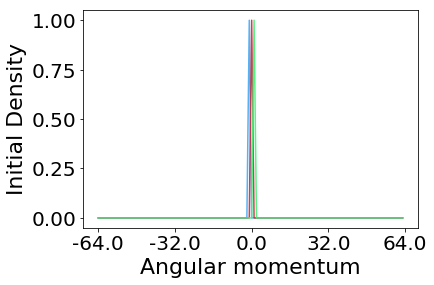

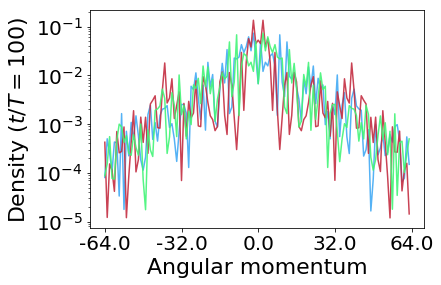

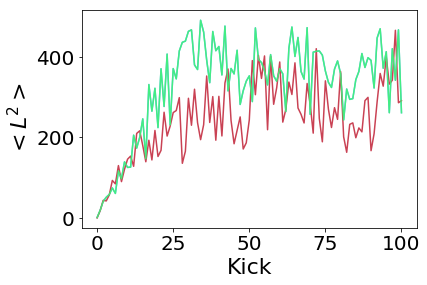

In [86]:
# Parameters
k1 = 6.0; # k^(1) kick strength of rotor 1
k2 = 6.0; # k^(2) kick strength of rotor 2
k3 = 6.0; # k^(3) kick strength of rotor 3
hbar = 1.0; #4.0*np.pi;#1.0;
T = 1.0; # kick period
I = 0.1; # moment of inertia
Ninitial_states = 1; # how many runs average over
Nbasis_states = 128; #2048; #512 # for efficiency with the FFT use a power of 2
Nkicks = 100; #2500
mblV = 0.002; #mblV is the parameter V in the MBL hamiltonian, needs to be taken small enough

Simulate_3rotors(False, INTERACTIONS_MBDL);

### Single-particle case

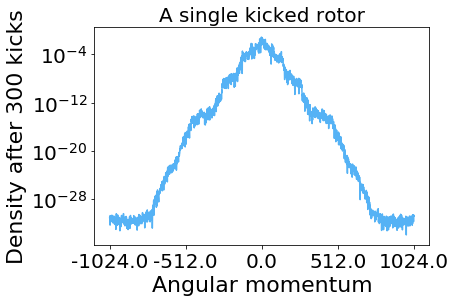

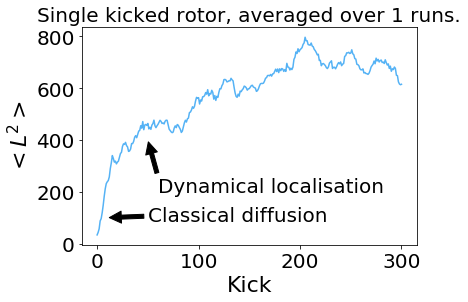

In [6]:
def PropagateWF(sWF):
    ''' A split operator propagator for one-particle case. '''
    sWF *= free_prop_oper_exp; # first free propagation in momentum space
    sWF = fftpack.ifft(sWF,overwrite_x=True); # inverse FFT to real space
    sWF *= kick_oper_exp; # apply the kick
    # back to angular momentum space by an FFT
    return fftpack.fft(sWF,overwrite_x=True);        
    

# Parameters
k1 = 6.0; # k^(1) kick strength of rotor 1
hbar = 1.0; #4.0*np.pi; #when hbar=4.0*np.pi, get quadratic increase, no localisation.
T = 1.0; # kick period
I = 1.0; # moment of inertia
Ninitial_states = 1; # how many runs average over
Nbasis_states = 2048; # for efficiency with the FFT use a power of 2
Nkicks = 300; #2500

# Definitions of numbers
#random.seed(123); # for generating reproducible random sequences
random.seed();
kbar = hbar*T/I;
K1 = k1/hbar; # scaled kick strength
arrayL2 = np.zeros(Nkicks+1);

# Definitions of operators
# Kick operator: COSINE KICKS (Definition of other functional forms for the Kicks goes here)
kick_oper_exp = [np.exp(-1j * K1*np.cos(i2*2.0*np.pi/Nbasis_states)) for i2 in range(Nbasis_states)]; 
# Free space propagator (regular kicked rotor):
free_prop_oper_exp = [np.exp(-1j * 0.5*kbar*(i2 - Nbasis_states/2.0)**2) for i2 in range(Nbasis_states)];    
# diagonal elements of the angular momentum operator in our diagonal basis, used to calculate <L^2>:
vecMomentum = [(i2 - Nbasis_states/2.0) for i2 in range(Nbasis_states)]; 

# Instead of FFT, the Floquet operator can be evaluated analytically as well:
#oper_Floquet =


# Simulate for Ninitial_states realisations
for _ in range(Ninitial_states):
    state_WF = PrepareInitialWF(10);

    # INITIAL <L^2>
    arrayL2[0] += EvaluateExpectationSquared(state_WF,vecMomentum);
 
    # TIME PROPAGATION
    for k in range(1,Nkicks+1):
        state_WF = PropagateWF(state_WF); # Can also just multiply by F, the floquet operator matrix Eq. 18.
        arrayL2[k] += EvaluateExpectationSquared(state_WF,vecMomentum);


PlotOvsStatespace_1body_1rotor(EvaluateDensity(state_WF), 'Density after %d kicks' %(Nkicks), True);

arrayL2 = arrayL2/Ninitial_states;
# arrayL2 contains the average of <L^2> for rotor 1 over Ninitial_states 
# realisations as a function of kick, i.e. arrayL2[0, 1, ..., Nkicks]

# plot <L^2> vs. kicks
plt.xlabel('Kick');
plt.ylabel('$< L^2 >$'); 
plt.plot(range(Nkicks+1),arrayL2, color='#42aaf4', alpha=0.9, label=" Rotor 1 ");
#plt.legend(loc="best");
plt.title('Single kicked rotor, averaged over %d runs.' %(Ninitial_states));
plt.annotate('Dynamical localisation', xy=(50, 400), xytext=(60, 200), arrowprops=dict(facecolor='black', shrink=0.05));
plt.annotate('Classical diffusion', xy=(10, 100), xytext=(50,85), arrowprops=dict(facecolor='black', shrink=0.05));
#plt.savefig("E1.pdf", bbox_inches='tight');
plt.show();